## Import the liaberies

In [1]:
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 6.9 MB/s eta 0:00:00


## Import dataset

In [2]:
data= pd.read_csv('/content/twitter_training.csv')


In [3]:
data

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...
...,...,...,...,...
74676,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74677,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74678,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74679,9200,Nvidia,Positive,Just realized between the windows partition of...


## Rename columns

In [4]:
col_name= ['no','tweet_id','label','tweet_text']
data.columns=col_name

In [5]:
data

,no,tweet_id,label,tweet_text
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...
...,...,...,...,...
74676,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74677,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74678,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74679,9200,Nvidia,Positive,Just realized between the windows partition of...


In [6]:
data= data[['label','tweet_text']]

In [7]:
data

,label,tweet_text
0,Positive,I am coming to the borders and I will kill you...
1,Positive,im getting on borderlands and i will kill you ...
2,Positive,im coming on borderlands and i will murder you...
3,Positive,im getting on borderlands 2 and i will murder ...
4,Positive,im getting into borderlands and i can murder y...
...,...,...
74676,Positive,Just realized that the Windows partition of my...
74677,Positive,Just realized that my Mac window partition is ...
74678,Positive,Just realized the windows partition of my Mac ...
74679,Positive,Just realized between the windows partition of...


## Data Preprocessing

In [8]:
data.isnull().sum()

,0
label,0
tweet_text,686


In [9]:
data= data.dropna()

In [10]:
data['label'].unique()

array(['Positive', 'Neutral', 'Negative', 'Irrelevant'], dtype=object)

In [11]:
data['label'].value_counts()

,count
label,
Negative,22358
Positive,20654
Neutral,18108
Irrelevant,12875


In [12]:
data.isnull().sum()

,0
label,0
tweet_text,0


# Irrelevant-0 , Negative- 1, Neutral- 2, Positive-3

In [13]:
data['label'] = data['label'].map({'Negative': 1, 'Positive': 3, 'Neutral': 2, 'Irrelevant': 0 })


/tmp/ipython-input-13-1833296444.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['label'] = data['label'].map({'Negative': 1, 'Positive': 3, 'Neutral': 2, 'Irrelevant': 0 })


In [14]:
data

,label,tweet_text
0,3,I am coming to the borders and I will kill you...
1,3,im getting on borderlands and i will kill you ...
2,3,im coming on borderlands and i will murder you...
3,3,im getting on borderlands 2 and i will murder ...
4,3,im getting into borderlands and i can murder y...
...,...,...
74676,3,Just realized that the Windows partition of my...
74677,3,Just realized that my Mac window partition is ...
74678,3,Just realized the windows partition of my Mac ...
74679,3,Just realized between the windows partition of...


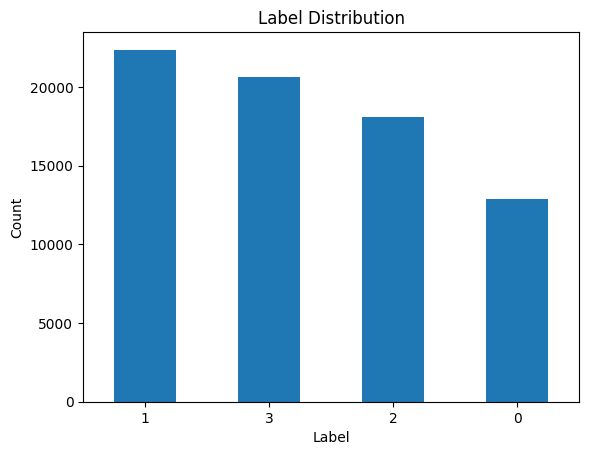

In [15]:
label_counts= data['label'].value_counts()

label_counts.plot(kind='bar', title='Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x labels for better readability (optional)
plt.show()

# Text Cleaning

In [16]:
import re
import string
import html
import emoji
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Ensure NLTK resources are available
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')

def clean_text(text):
    # 1. Remove HTML tags using regex
    text = re.sub(r'<.*?>', '', text)

    # 2. Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # 3. Remove @mentions
    text = re.sub(r'@\w+', '', text)

    # 4. Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # 5. Convert emojis to UTF-8-safe demojized form
    text = emoji.demojize(text, language='en')
    text = text.encode('utf-8', 'ignore').decode('utf-8')

    # 6. Convert to lowercase
    text = text.lower()

    # 7. Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    filtered_words = [word for word in words if word not in stop_words]

    return ' '.join(filtered_words)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [17]:
data['tweet_text']=data['tweet_text'].apply(clean_text)

/tmp/ipython-input-17-2006238059.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['tweet_text']=data['tweet_text'].apply(clean_text)


# Tokenization

In [18]:
import spacy

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

# Apply spaCy tokenization
data['tweet_text'] = data['tweet_text'].apply(lambda x: [token.text for token in nlp(x)])


/tmp/ipython-input-18-2920785973.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['tweet_text'] = data['tweet_text'].apply(lambda x: [token.text for token in nlp(x)])


# Apply Stemming

In [19]:
# Initialize the stemmer
stemmer = PorterStemmer()

# Apply Porter Stemmer to the tokenized text
data['tweet_text'] = data['tweet_text'].apply(lambda tokens: [stemmer.stem(token) for token in tokens])

/tmp/ipython-input-19-2453646818.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['tweet_text'] = data['tweet_text'].apply(lambda tokens: [stemmer.stem(token) for token in tokens])


In [20]:
# Join stemmed tokens back into text
data['tweet_text'] = data['tweet_text'].apply(lambda tokens: ' '.join(tokens))


/tmp/ipython-input-20-1207366948.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['tweet_text'] = data['tweet_text'].apply(lambda tokens: ' '.join(tokens))


# Apply vectorization

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data['tweet_text'])


# Train-test-split

In [22]:
y= data['label']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Apply Random Forest

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, cross_val_predict

In [25]:
rf = RandomForestClassifier(n_estimators=20, random_state=42)

# 5-fold cross-validation accuracy scores
cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-validated Accuracy Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")


Cross-validated Accuracy Scores: [0.86545608 0.86400878 0.86882338 0.86662725 0.86603598]
Mean CV Accuracy: 0.8662


In [26]:
y_pred = cross_val_predict(rf, X_train, y_train, cv=5)

In [27]:
rf.fit(X_train, y_train)
y_pred_test = rf.predict(X_test)

In [28]:
from sklearn.metrics import classification_report

class_names = ['Irrelevant', 'Negative', 'Neutral', 'Positive']

print(classification_report(y_test, y_pred_test, target_names=class_names))


              precision    recall  f1-score   support

  Irrelevant       0.94      0.82      0.87      2624
    Negative       0.89      0.91      0.90      4463
     Neutral       0.90      0.87      0.89      3589
    Positive       0.84      0.92      0.88      4123

    accuracy                           0.89     14799
   macro avg       0.89      0.88      0.88     14799
weighted avg       0.89      0.89      0.89     14799



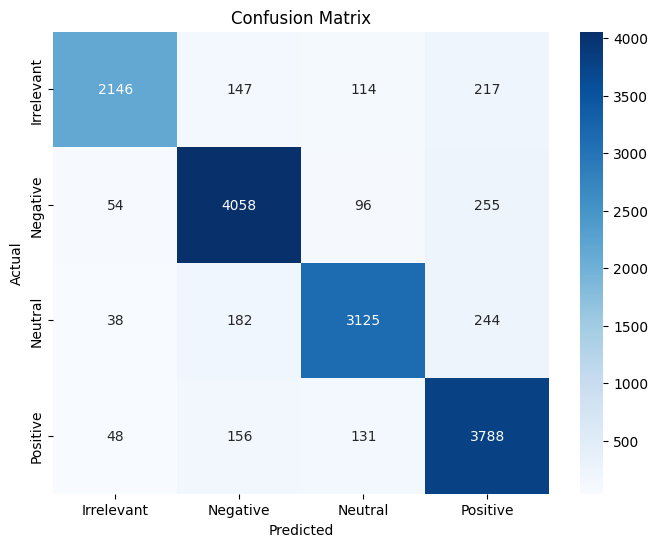

In [29]:
from sklearn.metrics import confusion_matrix

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

# Define class names
class_names = ['Irrelevant', 'Negative', 'Neutral', 'Positive']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Macro-average ROC AUC score: 0.9787


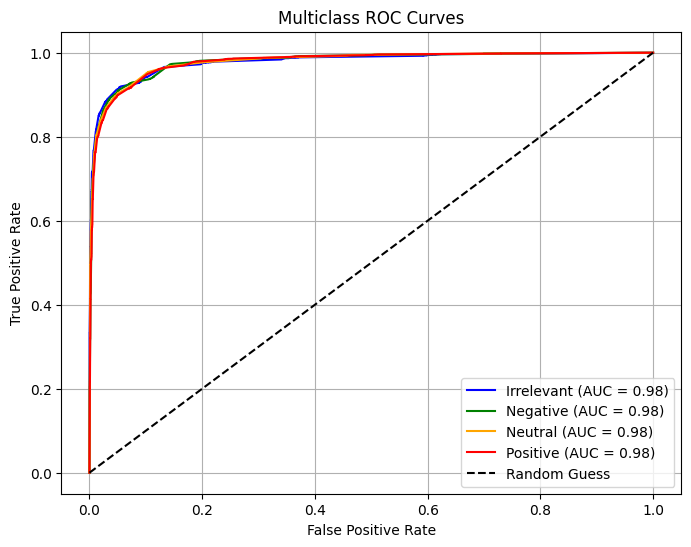

In [30]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
# Fit the model
rf.fit(X_train, y_train)

# Get class probabilities for ROC curve
y_score = rf.predict_proba(X_test)

# Binarize the true labels
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])
class_names = ['Irrelevant', 'Negative', 'Neutral', 'Positive']

# Compute ROC AUC score (macro-average)
auc_score = roc_auc_score(y_test_binarized, y_score, average='macro', multi_class='ovr')
print(f"Macro-average ROC AUC score: {auc_score:.4f}")

# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'orange', 'red']

for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    plt.plot(fpr, tpr, color=colors[i], label=f'{class_names[i]} (AUC = {roc_auc_score(y_test_binarized[:, i], y_score[:, i]):.2f})')

# Plot diagonal line for random guessing
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

# Labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


# Support Vector Classifiers

In [32]:
from sklearn.preprocessing import label_binarize
from sklearn.svm import SVC

# Define class names
class_names = ['Irrelevant', 'Negative', 'Neutral', 'Positive']

# Initialize SVC with probability enabled for ROC
svc = SVC()

# Fit the model on training data
svc.fit(X_train, y_train)


SVC(kernel='linear', probability=True, random_state=42)

In [33]:
# Predict labels on test set
y_pred1 = svc.predict(X_test)

In [34]:
# Classification Report
print("Classification Report (SVC):")
print(classification_report(y_test, y_pred1, target_names=class_names))

Classification Report (SVC):
              precision    recall  f1-score   support

  Irrelevant       0.81      0.69      0.74      2624
    Negative       0.80      0.83      0.81      4463
     Neutral       0.75      0.77      0.76      3589
    Positive       0.78      0.80      0.79      4123

    accuracy                           0.78     14799
   macro avg       0.78      0.77      0.78     14799
weighted avg       0.78      0.78      0.78     14799



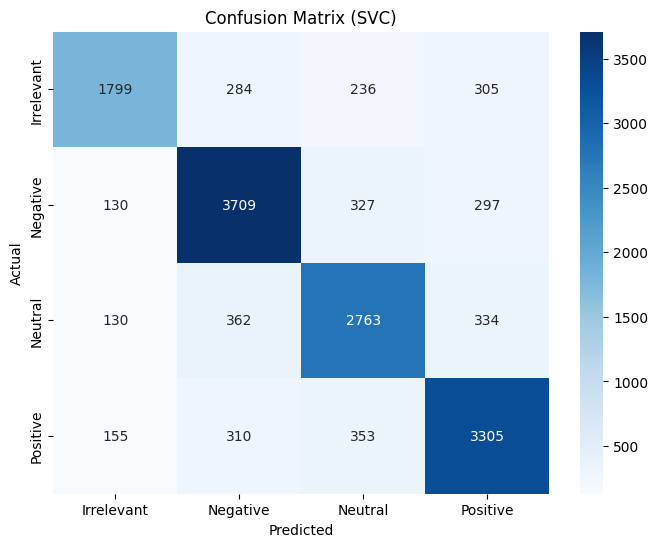

In [35]:
# Confusion Matrix
cm1 = confusion_matrix(y_test, y_pred1)

plt.figure(figsize=(8, 6))
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (SVC)")
plt.show()

Macro-average ROC AUC score (SVC): 0.9288


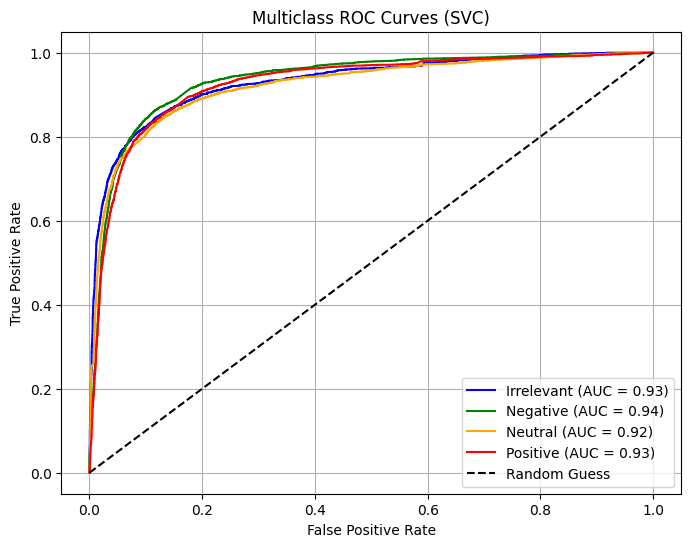

In [36]:
# ROC-AUC Curve and Score
# Predict class probabilities for ROC curve
y_score1 = svc.predict_proba(X_test)

# Binarize true labels for ROC AUC
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# Compute macro-average AUC
auc_score1 = roc_auc_score(y_test_binarized, y_score1, average='macro', multi_class='ovr')
print(f"Macro-average ROC AUC score (SVC): {auc_score1:.4f}")

# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'orange', 'red']

for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_score1[:, i])
    auc_class = roc_auc_score(y_test_binarized[:, i], y_score1[:, i])
    plt.plot(fpr, tpr, color=colors[i], label=f'{class_names[i]} (AUC = {auc_class:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curves (SVC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Apply Logistic regression

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, StratifiedKFold

In [32]:
# Define class names
class_names = ['Irrelevant', 'Negative', 'Neutral', 'Positive']

# Initialize Logistic Regression model
log_reg = LogisticRegression(multi_class='ovr', solver='liblinear', random_state=42)

# Define Stratified K-Fold cross-validator
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validated predictions (labels)
y_pred_cv = cross_val_predict(log_reg, X_train, y_train, cv=cv)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was depre

In [33]:
log_reg.fit(X_train, y_train)
y_pred_test1 = log_reg.predict(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Classification Report (Logistic Regression - Test Set):
              precision    recall  f1-score   support

  Irrelevant       0.78      0.54      0.64      2624
    Negative       0.73      0.80      0.76      4463
     Neutral       0.68      0.69      0.69      3589
    Positive       0.71      0.77      0.74      4123

    accuracy                           0.72     14799
   macro avg       0.73      0.70      0.71     14799
weighted avg       0.72      0.72      0.72     14799



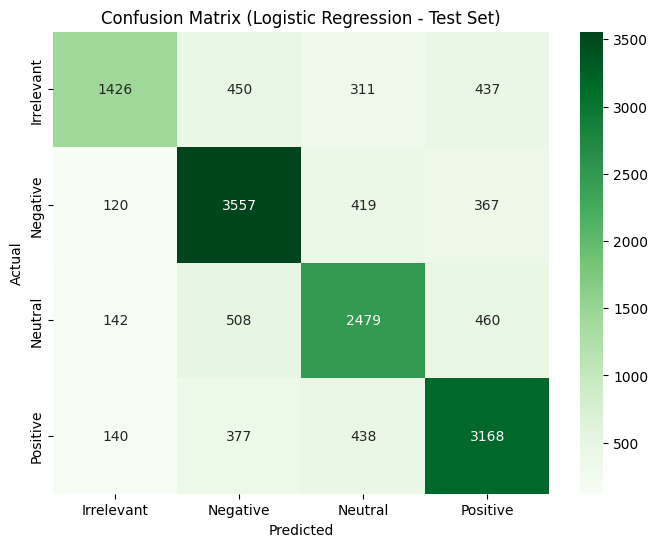

Macro-average ROC AUC score (Logistic Regression): 0.9047


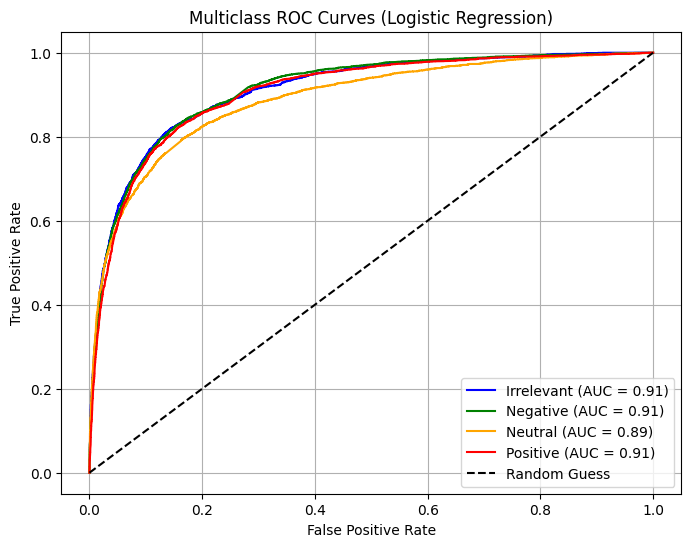

In [36]:
# Fit the model on full training data for ROC-AUC on test set
log_reg.fit(X_train, y_train)

# Predict on test set
y_pred_test = log_reg.predict(X_test)
y_proba_test = log_reg.predict_proba(X_test)

# Classification report on test set
print("Classification Report (Logistic Regression - Test Set):")
print(classification_report(y_test, y_pred_test, target_names=class_names))

# Confusion matrix on test set
cm_test = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Logistic Regression - Test Set)")
plt.show()

# ROC-AUC Curve and Score (Multiclass)
# Binarize y_test
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# Compute macro-average AUC
auc_score = roc_auc_score(y_test_binarized, y_proba_test, average='macro', multi_class='ovr')
print(f"Macro-average ROC AUC score (Logistic Regression): {auc_score:.4f}")

# Plot ROC curves per class
plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'orange', 'red']

for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_proba_test[:, i])
    auc_class = roc_auc_score(y_test_binarized[:, i], y_proba_test[:, i])
    plt.plot(fpr, tpr, color=colors[i], label=f'{class_names[i]} (AUC = {auc_class:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curves (Logistic Regression)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Apply XGBoost

In [37]:
from xgboost import XGBClassifier

In [39]:
# Define class names
class_names = ['Irrelevant', 'Negative', 'Neutral', 'Positive']

# Initialize and train the XGBoost classifier
xgb_clf = XGBClassifier(objective='multi:softprob', num_class=4,
                        eval_metric='mlogloss', use_label_encoder=False,
                        random_state=42)

xgb_clf.fit(X_train, y_train)

# Predict class labels and probabilities on test set
y_pred = xgb_clf.predict(X_test)
y_proba = xgb_clf.predict_proba(X_test)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:51:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [40]:
# Classification Report
print("Classification Report (XGBoost):")
print(classification_report(y_test, y_pred, target_names=class_names))

Classification Report (XGBoost):
              precision    recall  f1-score   support

  Irrelevant       0.75      0.36      0.48      2624
    Negative       0.59      0.83      0.69      4463
     Neutral       0.67      0.55      0.61      3589
    Positive       0.67      0.69      0.68      4123

    accuracy                           0.64     14799
   macro avg       0.67      0.61      0.61     14799
weighted avg       0.66      0.64      0.63     14799



In [ ]:
# Confusion Matrix
cm3 = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm3, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (XGBoost)")
plt.show()

Macro-average ROC AUC score (XGBoost): 0.8627


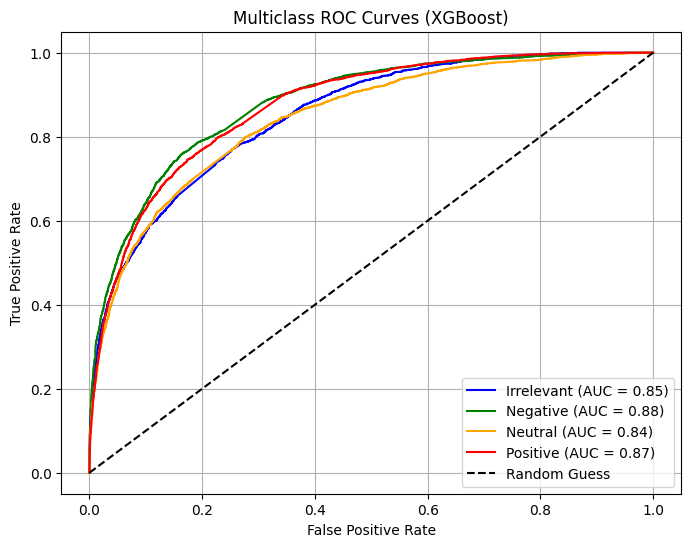

In [41]:

# ROC-AUC Curve and Score
# Binarize y_test
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# Compute macro-average AUC
auc_score = roc_auc_score(y_test_binarized, y_proba, average='macro', multi_class='ovr')
print(f"Macro-average ROC AUC score (XGBoost): {auc_score:.4f}")

# Plot ROC curves per class
plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'orange', 'red']

for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_proba[:, i])
    auc_class = roc_auc_score(y_test_binarized[:, i], y_proba[:, i])
    plt.plot(fpr, tpr, color=colors[i], label=f'{class_names[i]} (AUC = {auc_class:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curves (XGBoost)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Apply XGBoost+Random Forest

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:13:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report (Fusion Model - XGBoost + Random Forest):
              precision    recall  f1-score   support

  Irrelevant       0.96      0.75      0.84      2624
    Negative       0.86      0.90      0.88      4463
     Neutral       0.88      0.84      0.86      3589
    Positive       0.81      0.92      0.86      4123

    accuracy                           0.86     14799
   macro avg       0.88      0.85      0.86     14799
weighted avg       0.87      0.86      0.86     14799



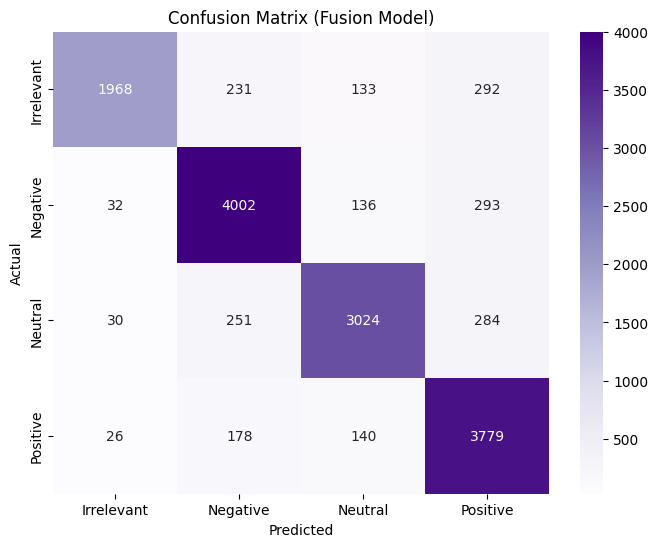

Macro-average ROC AUC (Fusion Model): 0.9753


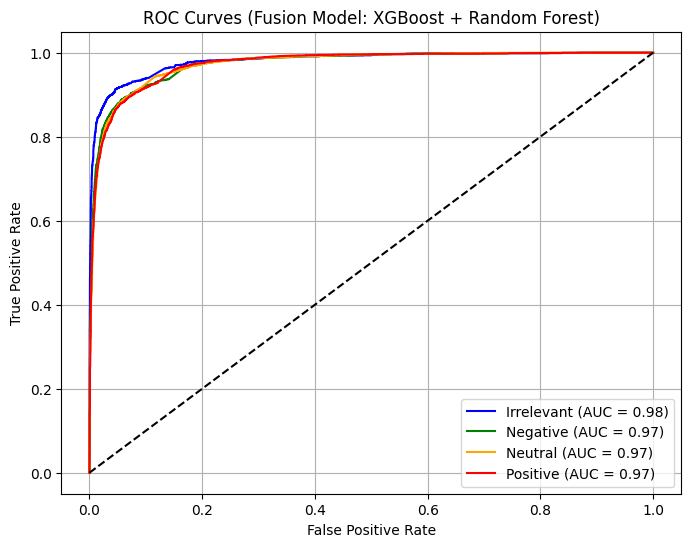

In [42]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define class names
class_names = ['Irrelevant', 'Negative', 'Neutral', 'Positive']

# ------------------ Define Individual Models ------------------
xgb_model7 = XGBClassifier(objective='multi:softprob', num_class=4,
                           eval_metric='mlogloss', use_label_encoder=False,
                           random_state=42)

rf_model7 = RandomForestClassifier(n_estimators=100, random_state=42)

# ------------------ Voting Ensemble ------------------
# Soft voting uses predicted probabilities
fusion_model7 = VotingClassifier(
    estimators=[('xgb', xgb_model7), ('rf', rf_model7)],
    voting='soft'
)

# Train ensemble
fusion_model7.fit(X_train, y_train)

# Predict and get probabilities
y_pred7 = fusion_model7.predict(X_test)
y_proba7 = fusion_model7.predict_proba(X_test)

# ------------------ Evaluation ------------------

# Classification Report
print("Classification Report (Fusion Model - XGBoost + Random Forest):")
print(classification_report(y_test, y_pred7, target_names=class_names))

# Confusion Matrix
cm7 = confusion_matrix(y_test, y_pred7)
plt.figure(figsize=(8, 6))
sns.heatmap(cm7, annot=True, fmt='d', cmap='Purples',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Fusion Model)")
plt.show()

# ------------------ ROC-AUC ------------------

# Binarize y_test
y_test_bin7 = label_binarize(y_test, classes=[0, 1, 2, 3])

# Compute macro-average AUC
auc_score7 = roc_auc_score(y_test_bin7, y_proba7, average='macro', multi_class='ovr')
print(f"Macro-average ROC AUC (Fusion Model): {auc_score7:.4f}")

# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'orange', 'red']

for i in range(len(class_names)):
    fpr7, tpr7, _ = roc_curve(y_test_bin7[:, i], y_proba7[:, i])
    auc_class7 = roc_auc_score(y_test_bin7[:, i], y_proba7[:, i])
    plt.plot(fpr7, tpr7, color=colors[i], label=f'{class_names[i]} (AUC = {auc_class7:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Fusion Model: XGBoost + Random Forest)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
